In [29]:
import numpy as np
from numpy.random import random, choice
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(1, '/Users/richard/Documents/projects/py_learning/sussex/Dissertation/gym')

import gym

In [30]:
desc = [
    "SFFFFFFF",
    "FFFFFFFF",
    "FFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHGHF",
    "FFFHFFFF",
]

env = gym.make('FrozenLake-v1', is_slippery=False, map_name="8x8", desc=desc)

In [31]:
print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

Action space =  Discrete(4)
Observation space =  Discrete(64)


In [32]:
actionsDict = {}
actionsDict[0] = " L "
actionsDict[1] = " D "
actionsDict[2] = " R "
actionsDict[3] = " U "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

In [33]:
env.reset()
env.render()

In [34]:
# optimalPolicy = ["R/D"," R "," D "," L ",
#                  " D "," - "," D "," - ",
#                  " R ","R/D"," D "," - ",
#                  " - "," R "," R "," ! ",]
    
# print("Optimal policy:")
# idxs = [0,4,8,12]
# for idx in idxs:
#     print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
#           optimalPolicy[idx+2], optimalPolicy[idx+3])

In [35]:
def action_epsilon_greedy(q, s, epsilon=0.05):
    if np.random.rand() > epsilon:
        return np.argmax(q[s])
    return np.random.randint(4)

def get_action_epsilon_greedy(epsilon):
    return lambda q,s: action_epsilon_greedy(q, s, epsilon=epsilon)

In [36]:
def greedy_policy(q, s):
    return np.argmax(q[s])

In [37]:
def average_performance(policy_fct, q):
    acc_returns = 0.
    n = 500
    for i in range(n):
        done = False
        s = env.reset()
        while not done:
            a = policy_fct(q, s)
            s, reward, done, info = env.step(a)
            acc_returns += reward
    return acc_returns/n

In [38]:
# parameters for sarsa(lambda)
episodes = 30000
STEPS = 500
gamma = 0.9
alpha = 0.05
epsilon_start = 0.2
epsilon_end = 0.001
epsilon_annealing_stop = int(episodes/2)
eligibility_decay = 0.3

GOAL_INDEX = 53

In [39]:

q = np.ones((env.observation_space.n, env.action_space.n))
# Set q(terminal,*) equal to 0
q[19,:] = 0.0
q[29,:] = 0.0
q[35,:] = 0.0
q[41,:] = 0.0
q[42,:] = 0.0
q[46,:] = 0.0
q[49,:] = 0.0
q[52,:] = 0.0
q[54,:] = 0.0
q[59,:] = 0.0

q[GOAL_INDEX,:] = 0.0 #goal

performance = np.ndarray(episodes//STEPS)

In [40]:
def resolveActionState(actionState):

    index = np.argmax(actionState)

    if index == 0: #left
        vertical = 0
        horizontal = actionState[index] *-1
    elif index == 1: #down
        vertical = actionState[index] *-1
        horizontal = 0
    elif index == 2: #right
        vertical = 0
        horizontal = actionState[index]
    elif index == 3: #up
        vertical = actionState[index]
        horizontal = 0
        
    return horizontal, vertical
    

In [46]:
from IPython.display import display, clear_output
import time 

def getGoalCoordinates(goal_index):
    side = int(np.sqrt(env.observation_space.n))
    x= goal_index%side
    y= int(np.floor(goal_index/side))

    return x, y

def plotActionStateQuiver():

    dim=int(np.sqrt(env.observation_space.n))    
    fig1, ax1 = plt.subplots(figsize=(5,5))
    
    policyFound = [resolveActionState(q[x,:]) for x in range(env.observation_space.n)]
    
    
    i = np.arange(0,dim) #rows
    j = np.arange(0,dim) #colums

    ii, jj = np.meshgrid(i,j)#, indexing='ij')

    # print("row indices:\n{}\n".format(ii))
    # print("column indices:\n{}".format(jj))

    U = np.reshape([i[0] for i in policyFound], (dim, dim))
    V = np.reshape([i[1] for i in policyFound], (dim, dim))

    ax1.cla()


    
    ax1.scatter([0],[0], c='g', s=500, marker='^') #origin

    x, y = getGoalCoordinates(GOAL_INDEX)
    ax1.scatter([x],[y], c='r', s=500, marker='o') #goal
    QP = ax1.quiver(ii,jj, U, V)
    plt.gca().invert_yaxis()
    # 
    # ax.set_aspect('equal')
    # plt.grid()
    # plt.show()
    # drawing updated values

    display(fig1)    
    clear_output(wait = True)
    # ax.clear()
    plt.pause(0.1)
    

In [42]:

for episode in range(episodes):

    inew = min(episode,epsilon_annealing_stop)
    epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
    
    E = np.zeros((env.observation_space.n, env.action_space.n))
    
    state = env.reset()
    action = action_epsilon_greedy(q, state, epsilon)

    while True:

        E = eligibility_decay * gamma * E
        E[state, action] += 1
        
        new_state, reward, done, info = env.step(action)
        
        new_action = action_epsilon_greedy(q, new_state, epsilon)

        delta = reward + gamma * q[new_state, new_action] - q[state, action]
        q = q + alpha * delta * E 

        state, action = new_state, new_action

        if done:
            break

    # only for plotting the performance, not part of the algorithm 
    if episode%STEPS == 0:
        performance[episode//STEPS] = average_performance(get_action_epsilon_greedy(epsilon), q=q)

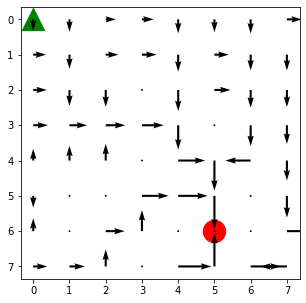

In [47]:
plotActionStateQuiver()

Text(0, 0.5, 'Average reward of an epoch')

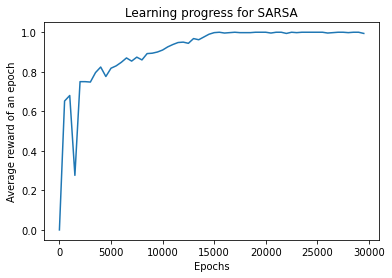

In [17]:
plt.plot(STEPS*np.arange(episodes//STEPS), performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")

In [18]:
greedyPolicyAvgPerf = average_performance(greedy_policy, q=q)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 1.0


In [19]:
q = np.round(q,3)
print("(A,S) Value function =", q.shape)
print("First row")
print(q[0:8,:])
print("Second row")
print(q[8:16,:])
print("Third row")
print(q[16:24,:])
print("Fourth row")
print(q[24:32,:])
print("Fith row")
print(q[32:40,:])
print("Six row")
print(q[40:48,:])
print("Seventh row")
print(q[48:56,:])
print("Eighth row")
print(q[56:64,:])

(A,S) Value function = (64, 4)
First row
[[0.284 0.294 0.346 0.286]
 [0.287 0.35  0.384 0.322]
 [0.321 0.426 0.377 0.343]
 [0.334 0.399 0.437 0.38 ]
 [0.372 0.508 0.37  0.425]
 [0.368 0.416 0.374 0.364]
 [0.399 0.439 0.407 0.404]
 [0.426 0.428 0.426 0.426]]
Second row
[[0.246 0.252 0.345 0.229]
 [0.244 0.28  0.418 0.249]
 [0.324 0.376 0.473 0.347]
 [0.355 0.004 0.526 0.364]
 [0.439 0.586 0.42  0.43 ]
 [0.396 0.417 0.476 0.376]
 [0.396 0.54  0.414 0.401]
 [0.446 0.444 0.444 0.443]]
Third row
[[0.278 0.282 0.277 0.274]
 [0.305 0.315 0.301 0.305]
 [0.328 0.447 0.116 0.327]
 [0.    0.    0.    0.   ]
 [0.    0.654 0.477 0.499]
 [0.421 0.166 0.543 0.41 ]
 [0.451 0.63  0.442 0.445]
 [0.481 0.489 0.482 0.48 ]]
Fourth row
[[0.307 0.309 0.32  0.304]
 [0.319 0.333 0.378 0.321]
 [0.344 0.347 0.54  0.313]
 [0.394 0.032 0.636 0.051]
 [0.536 0.729 0.    0.564]
 [0.    0.    0.    0.   ]
 [0.175 0.714 0.499 0.501]
 [0.535 0.554 0.522 0.524]]
Fith row
[[0.335 0.328 0.336 0.334]
 [0.345 0.324 0.346 0.3

In [20]:
def resolveActionDict(x, actionState):
    if x == GOAL_INDEX:
        return " ! "
    elif all(v == 0 for v in actionState):
        return " - "
    else:
        return actionsDict[np.argmax(actionState)]
    

In [21]:

policyFound = [resolveActionDict(x, q[x,:]) for x in range(env.observation_space.n)]

print("Greedy policy found:")
idxs = np.arange(0, env.observation_space.n, int(np.sqrt(env.observation_space.n)))
for idx in idxs:
    print(policyFound[idx+0], policyFound[idx+1], 
          policyFound[idx+2], policyFound[idx+3],
          policyFound[idx+4], policyFound[idx+5],
          policyFound[idx+6], policyFound[idx+7])

print(" ")

# print("Optimal policy:")
# idxs = [0,4,8,12]
# for idx in idxs:
#     print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
#           optimalPolicy[idx+2], optimalPolicy[idx+3])

Greedy policy found:
 R   R   D   R   D   D   D   D 
 R   R   R   R   D   R   D   L 
 D   D   D   -   D   R   D   D 
 R   R   R   R   D   -   D   D 
 R   R   U   -   R   D   L   L 
 D   -   -   R   R   D   -   D 
 L   -   R   U   -   !   -   D 
 R   R   U   -   R   U   L   L 
 
